In [1]:
#!pip install pystan~=2.14

In [2]:
#pip install --upgrade pip setuptools wheel


In [3]:
#pip install prophet

# Import data

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib as plt
import seaborn as sns
# url = "https://raw.githubusercontent.com/Kanchan786786/Capstone_project-/refs/heads/main/Datasets/AAPL_1D.csv"
# df = pd.read_csv(url)

In [5]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

meta = pd.read_csv("META.csv")
meta = meta[2:]
meta = meta.reset_index()
meta = meta.drop(columns=["index"])
# Rename 'Date' column in meta to 'Price', the original column name in the CSV.
meta = meta.rename(columns={"Price":"Date"})
columns_to_convert = ["Close", "High", "Low", "Open"]
meta.head()

meta[columns_to_convert] = meta[columns_to_convert].astype(float)
meta['Date'] = pd.to_datetime(meta['Date']) # Convert the 'Date' column to datetime
meta['Volume'] = meta['Volume'].astype(int)
# meta.head() # Uncomment to check the DataFrame structure

df = meta
# Now you can filter using the 'Date' column:
df = df[df['Date']>=pd.Timestamp(2020,1,1)].reset_index().drop(columns=["index"]) # Use pd.Timestamp
df = df[df['Date']<pd.Timestamp(2025,1,31)] # Use pd.Timestamp

In [6]:
# 1. Basic Information
print("\nDataset Information:\n")
print(df.info())

# 2. Summary Statistics
print("\nSummary Statistics:\n")
print(df.describe())

# 3. Checking for Missing Values
print("\nMissing Values:\n")
print(df.isnull().sum())


Dataset Information:

<class 'pandas.core.frame.DataFrame'>
Index: 1277 entries, 0 to 1276
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1277 non-null   datetime64[ns]
 1   Close   1277 non-null   float64       
 2   High    1277 non-null   float64       
 3   Low     1277 non-null   float64       
 4   Open    1277 non-null   float64       
 5   Volume  1277 non-null   int32         
dtypes: datetime64[ns](1), float64(4), int32(1)
memory usage: 64.8 KB
None

Summary Statistics:

                                Date        Close         High          Low  \
count                           1277  1277.000000  1277.000000  1277.000000   
mean   2022-07-15 11:43:38.950665728   305.080171   309.187244   300.787705   
min              2020-01-02 00:00:00    88.492935    90.035660    87.676766   
25%              2021-04-09 00:00:00   209.194061   211.732110   205.979214   
50%              2022-07-15 00:0

In [7]:
# Rename columns
new_columns = {col: col.replace(' ', '_').replace('Price', 'Date').replace('Week_Date', 'Day') for col in df.columns}
df = df.rename(columns=new_columns)

<Axes: xlabel='Date'>

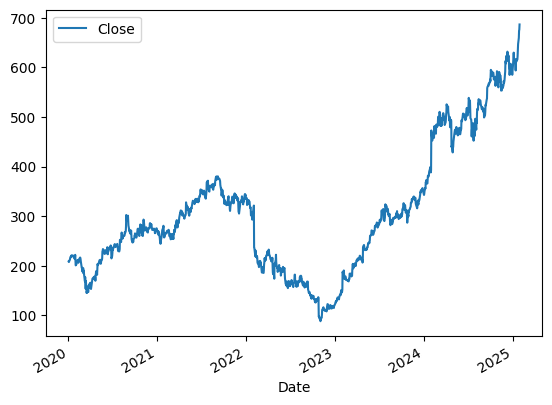

In [8]:
df.plot.line(y="Close", use_index=True, x='Date')

In [9]:
df["Tomorrow"] = df["Close"].shift(-1)
df["Target"] = (df["Tomorrow"] > df["Close"]).astype(int)

df = df.set_index('Date')

In [10]:
meta = df.loc["2000-01-01":].copy()
# del meta["Target_Variable_-_High"]
# del aapl["Target_Variable_-_Low"]

In [11]:
meta.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'Tomorrow', 'Target'], dtype='object')

In [12]:
meta = meta.reset_index()  # Moves Date back as a normal column
# print(meta[['Date', 'Day']])  # Now you can access both explicitly

In [13]:

# Delete the 'Target' column
if 'Target' in meta.columns:
    meta = meta.drop(columns=['Target'])

# Encode the 'Day' column (assuming it's categorical)
#if 'Day' in meta.columns:
 #   meta['Day'] = pd.Categorical(meta['Day']).codes

# Display the updated DataFrame
print(meta.head())


        Date       Close        High         Low        Open    Volume  \
0 2020-01-02  208.795914  208.805861  205.302385  205.780129  12077100   
1 2020-01-03  207.691147  209.413027  205.979214  206.238004  11188400   
2 2020-01-06  211.602722  211.781871  205.551241  205.730389  17058900   
3 2020-01-07  212.060547  213.573421  210.756694  211.821682  14912400   
4 2020-01-08  214.210419  215.225638  211.612661  212.000831  13475000   

     Tomorrow  
0  207.691147  
1  211.602722  
2  212.060547  
3  214.210419  
4  217.275970  


In [14]:

print("\nMissing Values:\n")
print(meta.isnull().sum())



Missing Values:

Date        0
Close       0
High        0
Low         0
Open        0
Volume      0
Tomorrow    1
dtype: int64


In [15]:

# Delete rows where 'Tomorrow' is missing
meta.dropna(subset=['Tomorrow'], inplace=True)

# Display the updated DataFrame to verify
print(meta.head())
print("\nMissing Values After Deletion:\n")
print(meta.isnull().sum())


        Date       Close        High         Low        Open    Volume  \
0 2020-01-02  208.795914  208.805861  205.302385  205.780129  12077100   
1 2020-01-03  207.691147  209.413027  205.979214  206.238004  11188400   
2 2020-01-06  211.602722  211.781871  205.551241  205.730389  17058900   
3 2020-01-07  212.060547  213.573421  210.756694  211.821682  14912400   
4 2020-01-08  214.210419  215.225638  211.612661  212.000831  13475000   

     Tomorrow  
0  207.691147  
1  211.602722  
2  212.060547  
3  214.210419  
4  217.275970  

Missing Values After Deletion:

Date        0
Close       0
High        0
Low         0
Open        0
Volume      0
Tomorrow    0
dtype: int64


In [16]:

numerical_features = meta.select_dtypes(include=np.number).columns
print("Numerical features:\n", numerical_features)

# Categorical features (if any)
categorical_features = meta.select_dtypes(exclude=np.number).columns
print("\nCategorical features:\n", categorical_features)


Numerical features:
 Index(['Close', 'High', 'Low', 'Open', 'Volume', 'Tomorrow'], dtype='object')

Categorical features:
 Index(['Date'], dtype='object')


In [17]:
meta[meta.isnull().any(axis=1)]

,Date,Close,High,Low,Open,Volume,Tomorrow


In [18]:
#!pip install ray

In [19]:
meta.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Tomorrow'], dtype='object')

In [20]:
meta

,Date,Close,High,Low,Open,Volume,Tomorrow
0,2020-01-02,208.795914,208.805861,205.302385,205.780129,12077100,207.691147
1,2020-01-03,207.691147,209.413027,205.979214,206.238004,11188400,211.602722
2,2020-01-06,211.602722,211.781871,205.551241,205.730389,17058900,212.060547
3,2020-01-07,212.060547,213.573421,210.756694,211.821682,14912400,214.210419
4,2020-01-08,214.210419,215.225638,211.612661,212.000831,13475000,217.275970
...,...,...,...,...,...,...,...
1271,2025-01-23,635.884277,636.034107,620.597890,626.802331,9910200,646.914429
1272,2025-01-24,646.914429,651.420429,633.636264,635.834321,19065300,659.293457
1273,2025-01-27,659.293457,663.279901,624.544343,626.053010,28399200,673.730591
1274,2025-01-28,673.730591,681.973257,658.883754,665.407978,20950100,675.888672


In [21]:
meta.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Tomorrow'], dtype='object')

In [22]:

# Convert 'Date' column to datetime objects if it's not already
meta['Date'] = pd.to_datetime(meta['Date'])

# Save the DataFrame to a CSV file
meta.to_csv('meta_processed.csv', index=False)  # index=False prevents writing row indices

In [23]:
pip install ace_tools

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip show ace_tools

Name: ace_tools
Version: 0.0
Summary: A placeholder empty package
Home-page: 
Author: Paul McMillan
Author-email: paul@mcmillan.ws
License: 
Location: C:\Users\laksh\anaconda3\envs\DAB111\Lib\site-packages
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [25]:
from sklearn.preprocessing import StandardScaler

# Selecting only numerical columns (excluding Date)
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
# numerical_cols = numerical_cols.drop("Day")

# Applying Standard Scaling
scaler = StandardScaler()
df_scaled = df.copy()  # Creating a copy to retain original data structure
df_scaled[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Saving the scaled data to a new CSV file
scaled_file_path = "meta_scaled.csv"
df_scaled.to_csv(scaled_file_path, index=False)

In [26]:
# Display the scaled DataFrame
df_scaled.head()  # or df_scaled if you want to display the whole DataFrame

,Close,High,Low,Open,Volume,Tomorrow,Target
Date,,,,,,,
2020-01-02,-0.740203,-0.764810,-0.742075,-0.761606,12077100,-0.749144,0
2020-01-03,-0.748696,-0.760184,-0.736815,-0.758088,11188400,-0.719078,1
2020-01-06,-0.718625,-0.742136,-0.740141,-0.761989,17058900,-0.715559,1
2020-01-07,-0.715105,-0.728486,-0.699686,-0.715176,14912400,-0.699034,1
2020-01-08,-0.698578,-0.715898,-0.693034,-0.713799,13475000,-0.675472,1


In [27]:
conda install -c conda-forge ace_tools

Note: you may need to restart the kernel to use updated packages.

Solving environment: ...working... unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: ...working... unsuccessful initial attempt using frozen solve. Retrying with flexible solve.


Error while loading conda entry point: anaconda-cloud-auth (cannot import name 'ChannelAuthBase' from 'conda.plugins.types' (C:\Users\laksh\anaconda3\Lib\site-packages\conda\plugins\types.py))
Error while loading conda entry point: anaconda-cloud-auth (cannot import name 'ChannelAuthBase' from 'conda.plugins.types' (C:\Users\laksh\anaconda3\Lib\site-packages\conda\plugins\types.py))

PackagesNotFoundError: The following packages are not available from current channels:

  - ace_tools

Current channels:

  - https://conda.anaconda.org/conda-forge/win-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https:/

# Scaled ata

**Loading scaled data**

In [28]:
file_path ="meta_scaled.csv"
df = pd.read_csv("meta_scaled.csv")

# Now you can work with the DataFrame 'df'
print(df.head())

      Close      High       Low      Open    Volume  Tomorrow  Target
0 -0.740203 -0.764810 -0.742075 -0.761606  12077100 -0.749144       0
1 -0.748696 -0.760184 -0.736815 -0.758088  11188400 -0.719078       1
2 -0.718625 -0.742136 -0.740141 -0.761989  17058900 -0.715559       1
3 -0.715105 -0.728486 -0.699686 -0.715176  14912400 -0.699034       1
4 -0.698578 -0.715898 -0.693034 -0.713799  13475000 -0.675472       1


# Descriptive analysis

In [29]:
meta = pd.read_csv("META.csv")
meta = meta[2:]
meta = meta.reset_index()
meta = meta.drop(columns=["index"])
# Rename 'Date' column in meta to 'Price', the original column name in the CSV.
meta = meta.rename(columns={"Price":"Date"})
columns_to_convert = ["Close", "High", "Low", "Open"]
meta.head()

meta[columns_to_convert] = meta[columns_to_convert].astype(float)
meta['Date'] = pd.to_datetime(meta['Date']) # Convert the 'Date' column to datetime
meta['Volume'] = meta['Volume'].astype(int)
# meta.head() # Uncomment to check the DataFrame structure

df = meta
# Now you can filter using the 'Date' column:
df = df[df['Date']>=pd.Timestamp(2020,1,1)].reset_index().drop(columns=["index"]) # Use pd.Timestamp
df = df[df['Date']<pd.Timestamp(2025,1,31)] # Use pd.Timestamp

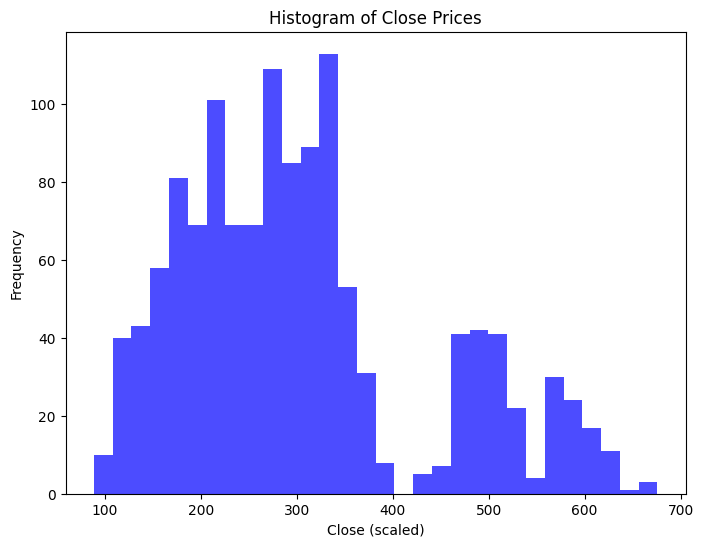

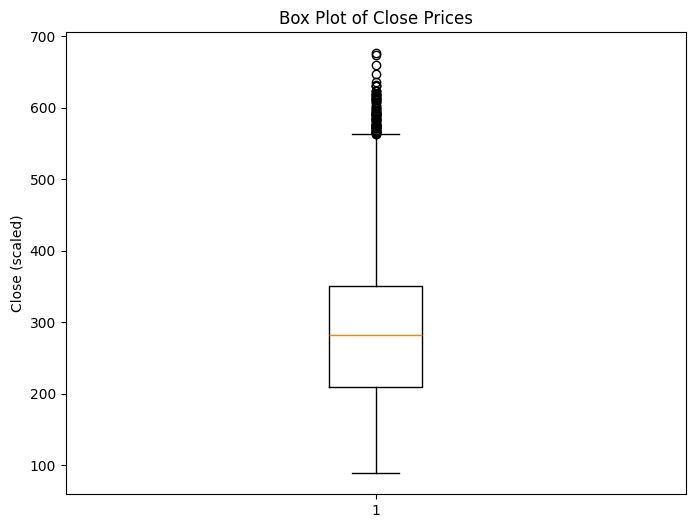

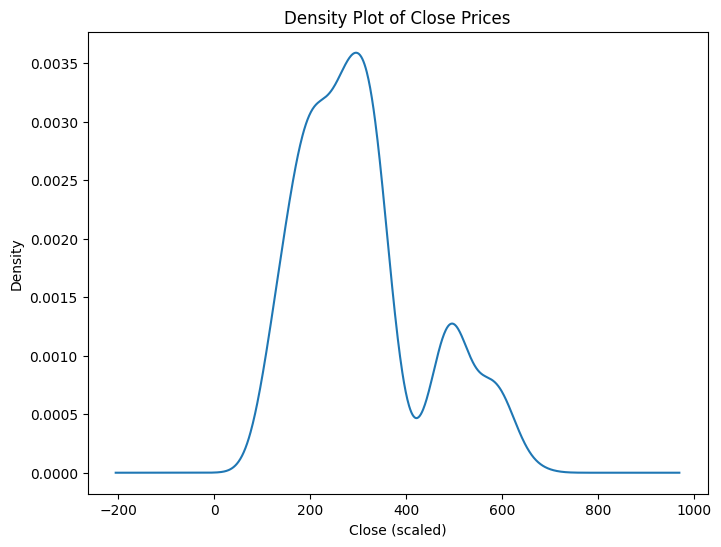

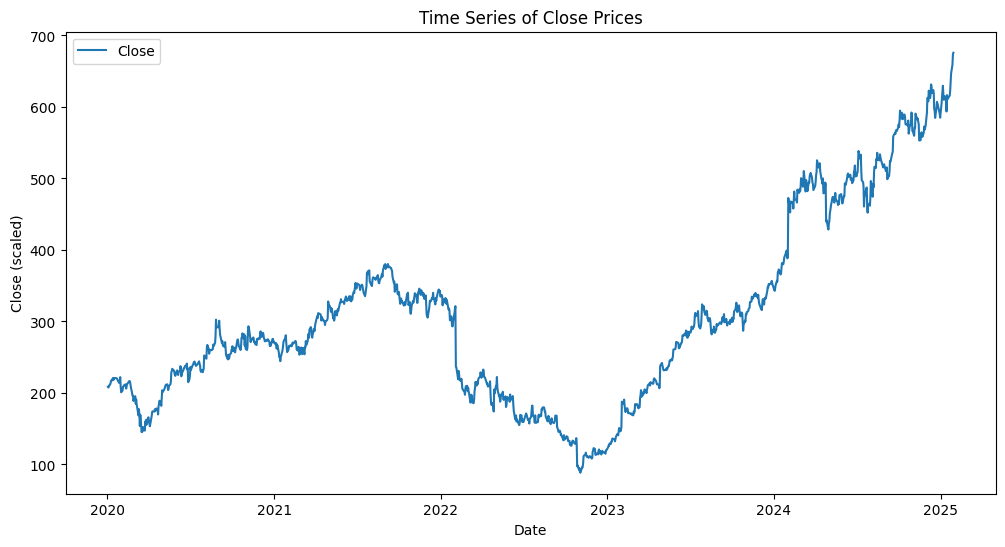

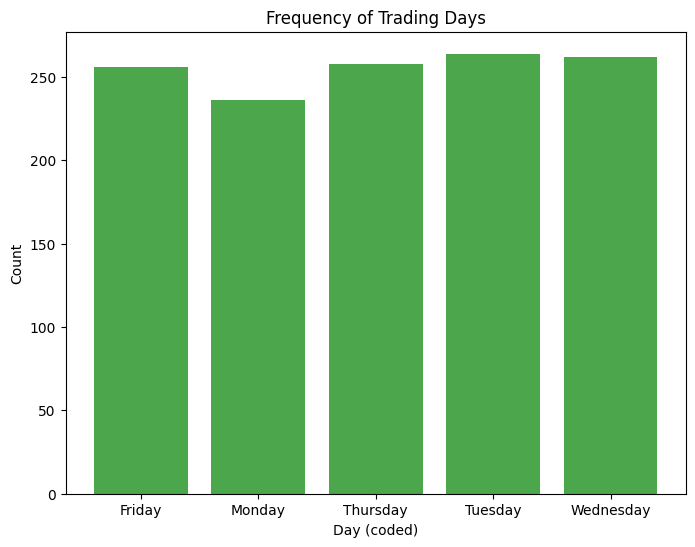

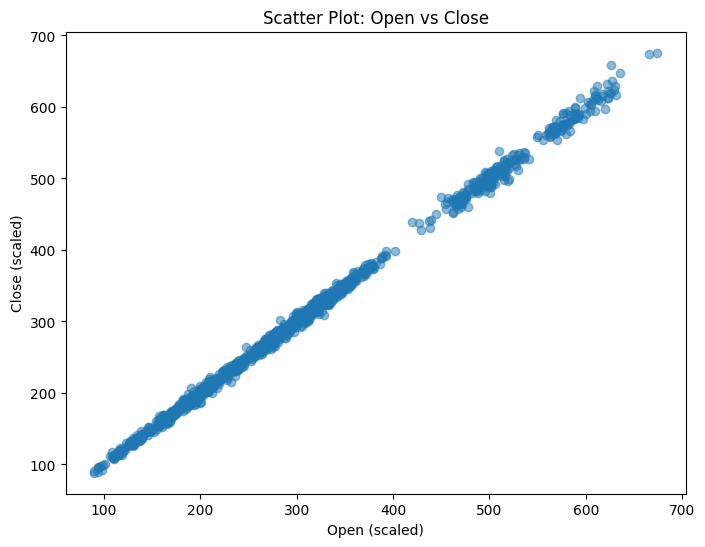

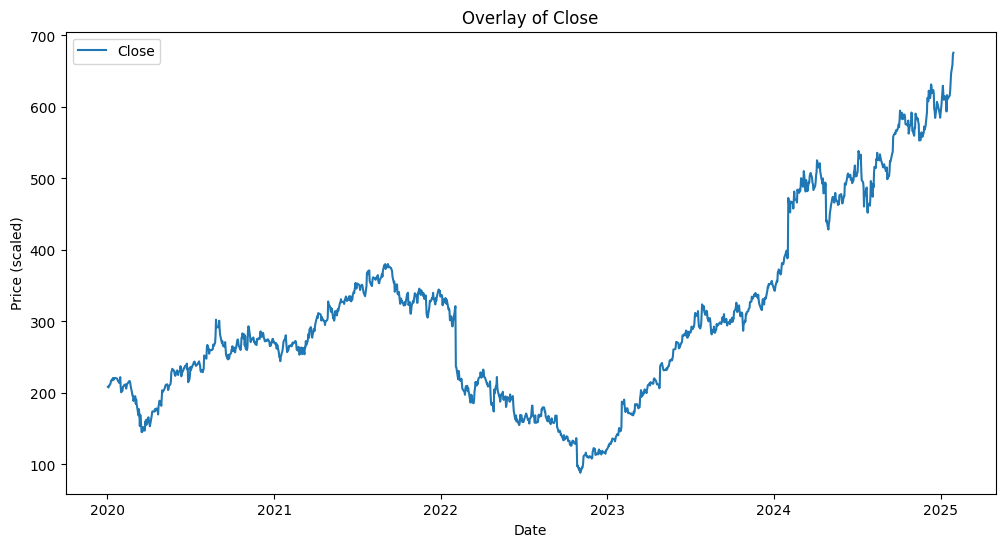

mplfinance is not installed; skipping candlestick chart.


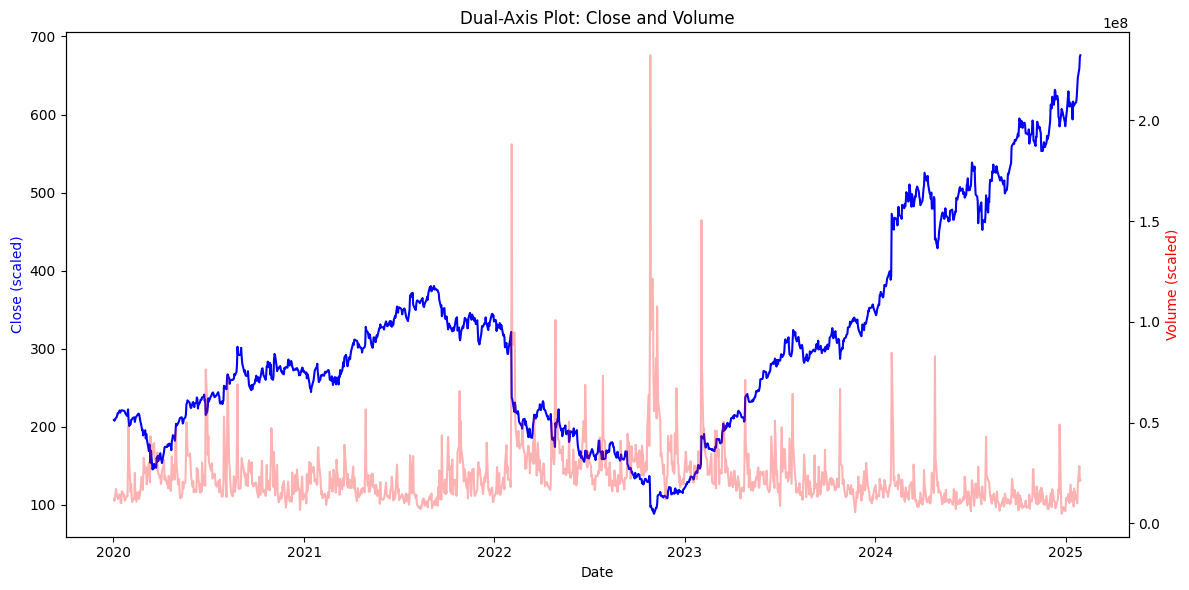

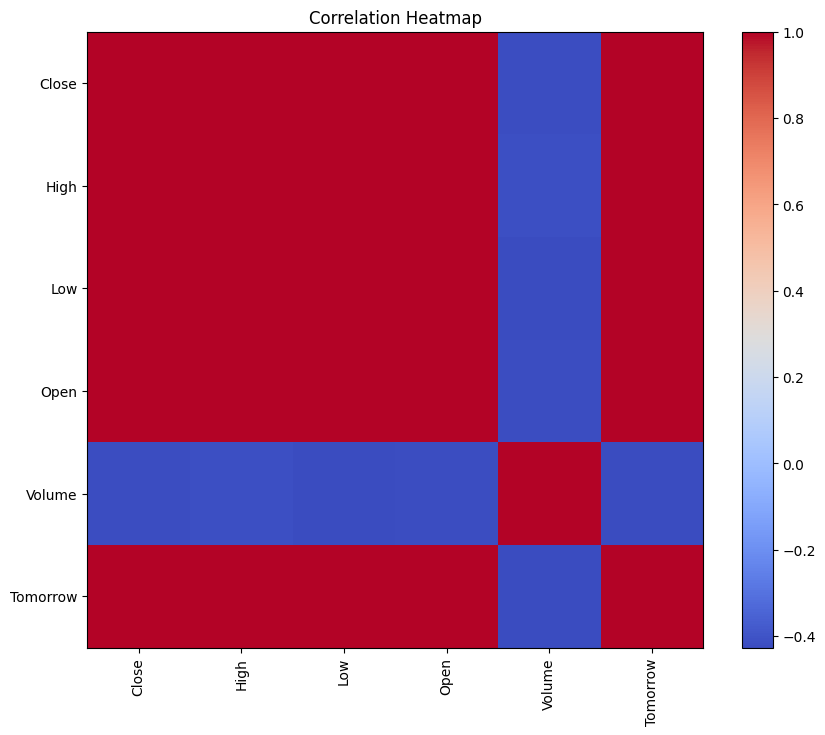

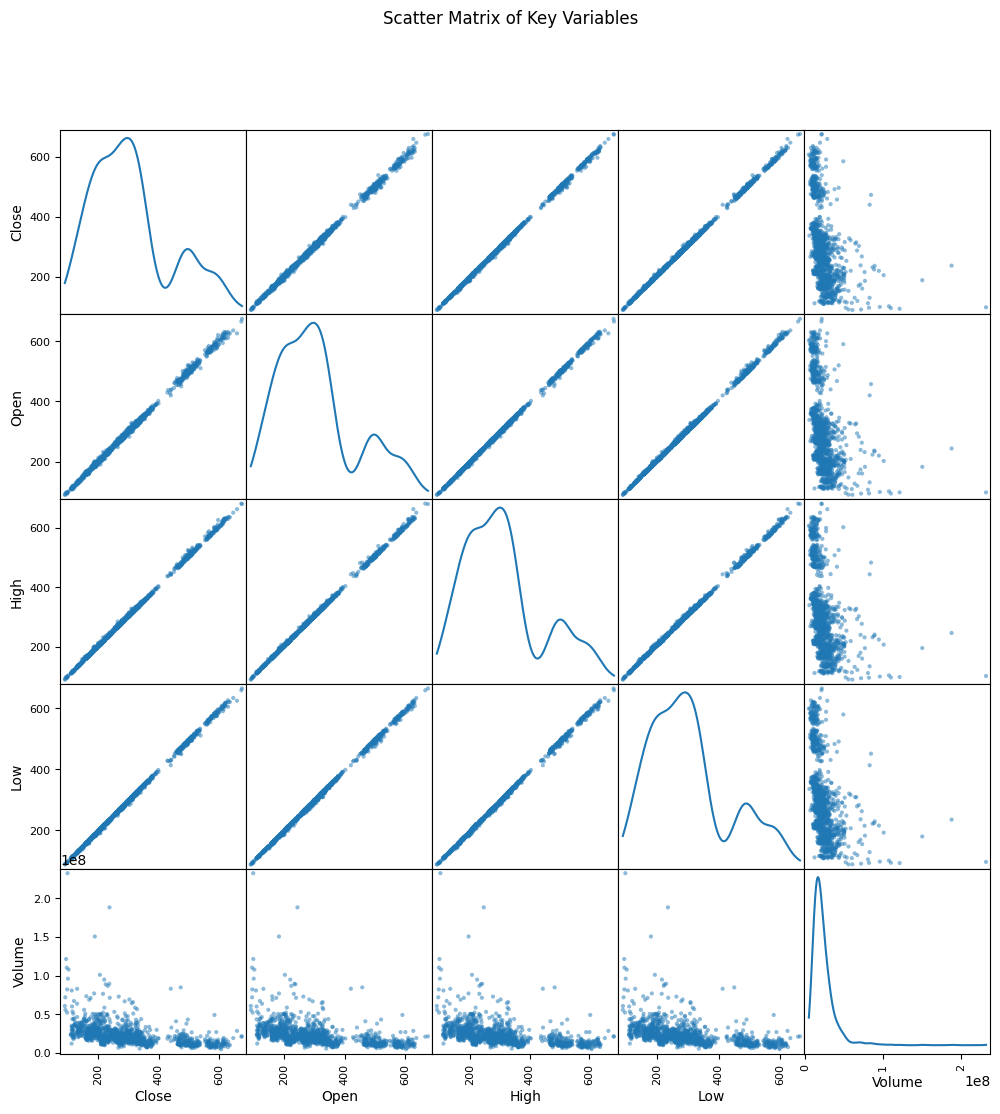

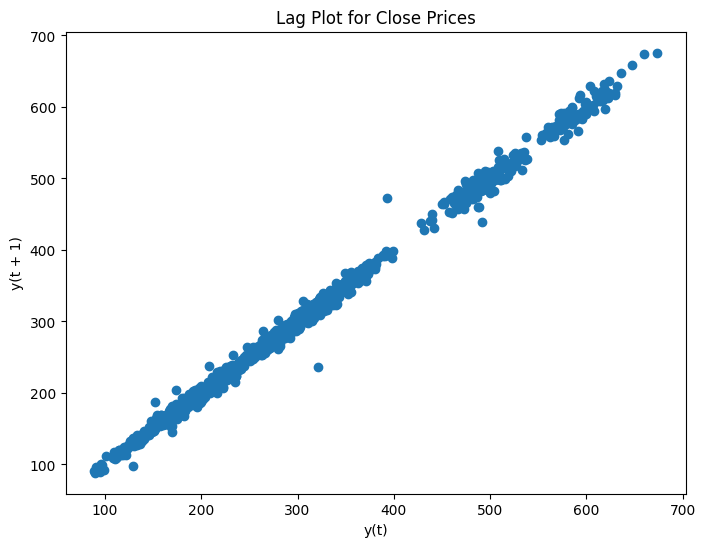

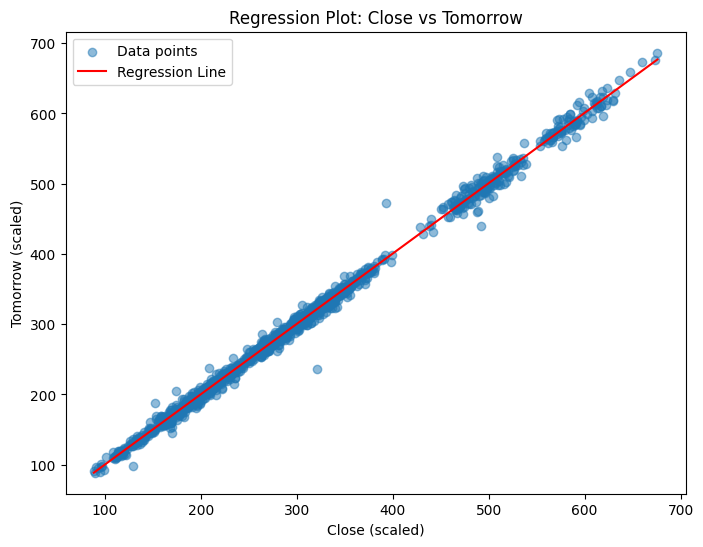

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Read the CSV file (update the path if necessary)
# file_path = "META.csv"
# df = pd.read_csv(file_path)

# Convert Date column to datetime
# df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day_name() 
df['Tomorrow'] = df['Close'].shift(-1)
# Remove any rows with NaN values in 'Close' or 'Tomorrow'
df = df.dropna(subset=['Close', 'Tomorrow'])

#########################################
# Univariate Analysis
#########################################

# 1. Histogram for Close Prices
plt.figure(figsize=(8,6))
plt.hist(df['Close'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Close Prices')
plt.xlabel('Close (scaled)')
plt.ylabel('Frequency')
plt.show()
# Inference:
# • This histogram shows the distribution of the scaled closing prices.
# • You can check for skewness, modality, and outliers.
# • In our dataset, the values are tightly centered around a specific level.

# 2. Box Plot for Close Prices
plt.figure(figsize=(8,6))
plt.boxplot(df['Close'], vert=True)
plt.title('Box Plot of Close Prices')
plt.ylabel('Close (scaled)')
plt.show()
# Inference:
# • The box plot reveals the median, quartiles, and any potential outliers.
# • A narrow box indicates little spread in the scaled values.

# 3. Density Plot (KDE) for Close Prices
plt.figure(figsize=(8,6))
df['Close'].plot(kind='density')
plt.title('Density Plot of Close Prices')
plt.xlabel('Close (scaled)')
plt.show()
# Inference:
# • The density plot gives a smooth estimate of the distribution.
# • It confirms the overall shape seen in the histogram.

# 4. Time Series Line Plot of Close Prices
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Close')
plt.title('Time Series of Close Prices')
plt.xlabel('Date')
plt.ylabel('Close (scaled)')
plt.legend()
plt.show()
# Inference:
# • This time series shows how the closing price changes over time.
# • Trends, cycles, or volatility periods become visible.

# 5. Bar Chart for Frequency of Trading Days
plt.figure(figsize=(8,6))
day_counts = df['Day'].value_counts().sort_index()
plt.bar(day_counts.index.astype(str), day_counts.values, color='green', alpha=0.7)
plt.title('Frequency of Trading Days')
plt.xlabel('Day (coded)')
plt.ylabel('Count')
plt.show()
# Inference:
# • The bar chart shows the number of observations for each day code.
# • It helps to check if some days are under- or over-represented.

#########################################
# Bivariate Analysis
#########################################

# 6. Scatter Plot: Open vs Close
plt.figure(figsize=(8,6))
plt.scatter(df['Open'], df['Close'], alpha=0.5)
plt.title('Scatter Plot: Open vs Close')
plt.xlabel('Open (scaled)')
plt.ylabel('Close (scaled)')
plt.show()
# Inference:
# • There is typically a strong linear relationship between the opening and closing prices.
# • This plot confirms how closely these values track each other.

# 7. Overlay of Time Series: Close, SMA_50, and EMA_50
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Close')
plt.title('Overlay of Close')
plt.xlabel('Date')
plt.ylabel('Price (scaled)')
plt.legend()
plt.show()
# Inference:
# • The moving averages (SMA and EMA) follow the trend of the close price with a lag.
# • Crossovers between these lines and the price can hint at potential trading signals.

# 8. Candlestick Chart
# For the candlestick chart, we use mplfinance if available.
try:
    import mplfinance as mpf
    df_candle = df.copy()
    df_candle = df_candle.set_index('Date')
    # Select only the required OHLC columns
    df_candle = df_candle[['Open','High','Low','Close']]
    mpf.plot(df_candle, type='candle', style='charles', title='Candlestick Chart', volume=False)
except ImportError:
    print("mplfinance is not installed; skipping candlestick chart.")
# Inference:
# • The candlestick chart visualizes the open, high, low, and close for each day.
# • It is especially useful for identifying daily trading patterns.

# 9. Dual-Axis Plot: Close and Volume Over Time
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df['Date'], df['Close'], color='blue', label='Close')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close (scaled)', color='blue')
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['Volume'], color='red', label='Volume', alpha=0.3)
ax2.set_ylabel('Volume (scaled)', color='red')
plt.title('Dual-Axis Plot: Close and Volume')
fig.tight_layout()
plt.show()
# Inference:
# • This plot illustrates how trading volume corresponds with price movements.
# • Spikes in volume might coincide with sharp price changes.

# 10. Correlation Heatmap
# Select only numerical columns
df_numeric = df.select_dtypes(include=['number'])

# Compute and plot the correlation heatmap
plt.figure(figsize=(10,8))
corr = df_numeric.corr()
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation Heatmap')
plt.show()

# Inference:
# • The heatmap reveals the strength of linear relationships among all numerical variables.
# • Price-related columns (Open, Close, High, Low) often show very high correlations.

# 11. Scatter Matrix (Pair Plot) of Selected Variables
pd.plotting.scatter_matrix(df[['Close','Open','High','Low','Volume']], figsize=(12,12), alpha=0.5, diagonal='kde')
plt.suptitle('Scatter Matrix of Key Variables')
plt.show()
# Inference:
# • The scatter matrix provides a comprehensive view of pairwise relationships.
# • It helps to quickly spot any outlier or unusual relationships between variables.

# 12. Lag Plot for Close Prices
from pandas.plotting import lag_plot
plt.figure(figsize=(8,6))
lag_plot(df['Close'])
plt.title('Lag Plot for Close Prices')
plt.show()
# Inference:
# • The lag plot helps identify autocorrelation in the close prices.
# • A clear diagonal pattern suggests that today’s price is highly related to yesterday’s.

# 13. Regression Plot: Close vs Tomorrow

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(df['Close'], df['Tomorrow'], alpha=0.5, label='Data points')

# Calculate regression line
slope, intercept = np.polyfit(df['Close'], df['Tomorrow'], 1)

# Generate x and y values for the regression line
x_vals = np.linspace(df['Close'].min(), df['Close'].max(), 100)
y_vals = intercept + slope * x_vals

# Plot regression line
plt.plot(x_vals, y_vals, color='red', label='Regression Line')

# Titles and labels
plt.title('Regression Plot: Close vs Tomorrow')
plt.xlabel('Close (scaled)')
plt.ylabel('Tomorrow (scaled)')
plt.legend()

# Show plot
plt.show()

# Inference:
# • This plot examines the predictive relationship between the current close price and the next day’s value.
# • A strong linear trend suggests that today's closing price is a good predictor for tomorrow's price.


# Model Execution

Scaling code

In [31]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install prophet

C:\Users\laksh\anaconda3\envs\DAB111\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-09 17:22:10,744] A new study created in memory with name: no-name-ff011781-6de9-43d9-9481-c61f2a3a34c3


Detected 12 CPU cores.
Candidate Regressors (above threshold or forced): ['High', 'Low', 'Open', 'Volume', 'Tomorrow']


17:22:11 - cmdstanpy - INFO - Chain [1] start processing
17:22:12 - cmdstanpy - INFO - Chain [1] done processing
17:22:14 - cmdstanpy - INFO - Chain [1] start processing
17:22:14 - cmdstanpy - INFO - Chain [1] start processing
17:22:14 - cmdstanpy - INFO - Chain [1] start processing
17:22:14 - cmdstanpy - INFO - Chain [1] start processing
  0%|                                                                                            | 0/5 [00:00<?, ?it/s]17:22:15 - cmdstanpy - INFO - Chain [1] start processing
17:22:15 - cmdstanpy - INFO - Chain [1] done processing
17:22:15 - cmdstanpy - INFO - Chain [1] start processing
17:22:15 - cmdstanpy - INFO - Chain [1] start processing
17:22:15 - cmdstanpy - INFO - Chain [1] start processing
17:22:15 - cmdstanpy - INFO - Chain [1] start processing
17:22:15 - cmdstanpy - INFO - Chain [1] start processing

17:22:15 - cmdstanpy - INFO - Chain [1] start processing
  0%|                                                                               


✅ Best hyperparameters found by Optuna:
{'changepoint_prior_scale': 0.005420101932981475, 'seasonality_prior_scale': 6.564259421538855, 'interval_width': 0.65, 'daily_seasonality': True, 'use_High': True, 'use_Low': True, 'use_Open': True, 'use_Volume': True, 'use_Tomorrow': True}


17:22:56 - cmdstanpy - INFO - Chain [1] start processing
17:22:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|                                                                                            | 0/5 [00:00<?, ?it/s]17:22:57 - cmdstanpy - INFO - Chain [1] start processing
17:22:57 - cmdstanpy - INFO - Chain [1] done processing
 20%|████████████████▊                                                                   | 1/5 [00:00<00:02,  1.50it/s]17:22:57 - cmdstanpy - INFO - Chain [1] start processing
17:22:58 - cmdstanpy - INFO - Chain [1] done processing
 40%|█████████████████████████████████▌                                                  | 2/5 [00:01<00:02,  1.36it/s]17:22:58 - cmdstanpy - INFO - Chain [1] start processing
17:22:58 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:02<00:01,  1.29it/s]17:22:59 - cmdstanpy - INFO - Chain [1] start processing
17:22:59 - cmds


Cross-Validation Results for Different Horizons:
   horizon      mape      rmse       mae
0   7 days  0.007294  2.968040  2.491415
1  14 days  0.006897  2.835930  2.386477
2  30 days  0.006389  2.922483  2.283928


17:23:10 - cmdstanpy - INFO - Chain [1] start processing
17:23:10 - cmdstanpy - INFO - Chain [1] done processing
17:23:11 - cmdstanpy - INFO - Chain [1] start processing
17:23:11 - cmdstanpy - INFO - Chain [1] done processing
17:23:12 - cmdstanpy - INFO - Chain [1] start processing
17:23:13 - cmdstanpy - INFO - Chain [1] done processing
17:23:14 - cmdstanpy - INFO - Chain [1] start processing
17:23:14 - cmdstanpy - INFO - Chain [1] done processing
17:23:15 - cmdstanpy - INFO - Chain [1] start processing
17:23:15 - cmdstanpy - INFO - Chain [1] done processing


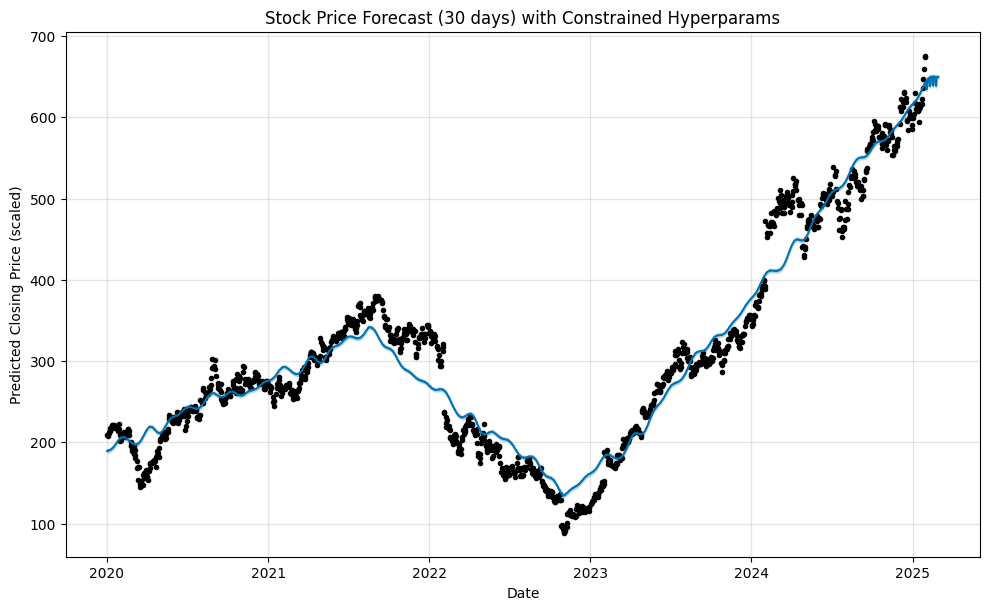


✅ 30-Day Forecast Results:
             ds        yhat  yhat_lower  yhat_upper
1276 2025-01-30  643.569012  641.304431  645.768363
1277 2025-01-31  644.248281  642.117797  646.358836
1278 2025-02-01  634.426907  632.018468  636.622901
1279 2025-02-02  635.185251  632.987323  637.369616
1280 2025-02-03  647.042603  644.690962  649.185892
1281 2025-02-04  647.232837  645.222367  649.372764
1282 2025-02-05  648.070058  645.814705  650.322273
1283 2025-02-06  648.376881  646.081806  650.335586
1284 2025-02-07  648.576805  646.367508  650.587142
1285 2025-02-08  638.274654  635.916631  640.395492
1286 2025-02-09  638.557080  636.440204  640.861398
1287 2025-02-10  649.949329  647.893554  652.153863
1288 2025-02-11  649.690808  647.575519  652.020619
1289 2025-02-12  650.100644  648.146397  652.387193
1290 2025-02-13  650.005905  647.704574  652.174328
1291 2025-02-14  649.833925  647.690780  651.956248
1292 2025-02-15  639.192726  637.078504  641.591483
1293 2025-02-16  639.171512  636.942

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]17:23:17 - cmdstanpy - INFO - Chain [1] start processing
17:23:17 - cmdstanpy - INFO - Chain [1] done processing
 20%|████████████████▊                                                                   | 1/5 [00:00<00:02,  1.41it/s]17:23:18 - cmdstanpy - INFO - Chain [1] start processing
17:23:18 - cmdstanpy - INFO - Chain [1] done processing
 40%|█████████████████████████████████▌                                                  | 2/5 [00:01<00:02,  1.40it/s]17:23:18 - cmdstanpy - INFO - Chain [1] start processing
17:23:19 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:02<00:01,  1.30it/s]17:23:19 - cmdstanpy - INFO - Chain [1] start processing
17:23:19 - cmdstanpy - INFO - Chain [1] done processing
 80%|███████████████████████████████████████████████████████████████████


✅ Final Model Performance Metrics (30-day horizon):
   horizon        mse      rmse       mae      mape     mdape     smape  \
0   3 days   5.991208  2.447694  2.052429  0.006529  0.006063  0.006555   
1   4 days   4.862154  2.205029  1.743725  0.005637  0.005373  0.005657   
2   5 days   2.944979  1.716094  1.522760  0.004442  0.004309  0.004445   
3   6 days   4.876827  2.208354  1.893808  0.005039  0.005369  0.005043   
4   7 days  10.436919  3.230622  2.259333  0.005267  0.005898  0.005279   
5   8 days  12.987812  3.603861  2.739758  0.006562  0.006471  0.006573   
6   9 days   9.591330  3.096987  2.348992  0.005726  0.006187  0.005725   
7  10 days   6.525645  2.554534  2.118583  0.005944  0.006187  0.005942   
8  11 days   5.098358  2.257954  1.866584  0.005388  0.005248  0.005383   
9  12 days   8.166285  2.857671  2.235918  0.006243  0.007376  0.006246   
10 13 days   6.828051  2.613054  1.888128  0.005514  0.006245  0.005518   
11 14 days  11.059566  3.325593  2.374686  0.00

In [33]:
import os
import multiprocessing
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from IPython.display import Audio, display

# ----------------------------------------------------------------------
# (A) ENV SETUP: Force single-threaded Stan + detect CPU cores
# ----------------------------------------------------------------------
os.environ["STAN_NUM_THREADS"] = "2"  # each Stan process uses 1 CPU thread
n_cpus = multiprocessing.cpu_count()
print(f"Detected {n_cpus} CPU cores.")

# (Optional) Force usage of cmdstanpy if you want:
# from prophet.utilities import set_backend
# set_backend("CMDSTANPY")

# ----------------------------------------------------------------------
# (B) DATA PREPARATION
# ----------------------------------------------------------------------
# 'df' should have columns: ["Date", "Close", "Tomorrow", ... other features ...]
df["Date"] = pd.to_datetime(df["Date"])

# Create separate DataFrame for Prophet:
df_prophet = df.rename(columns={"Date": "ds", "Close": "y"})

# ----------------------------------------------------------------------
# (C) IDENTIFY POTENTIAL REGRESSORS
# ----------------------------------------------------------------------
# We'll do a correlation threshold, but force-keep "Tomorrow" if it exists
correlation_threshold = 0.4  # can adjust
all_corr = df_numeric.corr()["Close"].drop(["Close"])  # drop itself
candidate_regressors = all_corr[abs(all_corr) >= correlation_threshold].index.tolist()

# Force-keep "Tomorrow" if it exists, even if correlation < threshold
if "Tomorrow" in df.columns and "Tomorrow" not in candidate_regressors:
    candidate_regressors.append("Tomorrow")

# Remove any date-like columns
candidate_regressors = [c for c in candidate_regressors if c not in ["Date", "ds"]]

print("Candidate Regressors (above threshold or forced):", candidate_regressors)

# ----------------------------------------------------------------------
# (D) DEFINE OBJECTIVE FUNCTION (OPTUNA) with Constrained Hyperparams
# ----------------------------------------------------------------------
def objective(trial):
    # Narrower hyperparam ranges to reduce overfitting
    cps = trial.suggest_float("changepoint_prior_scale", 0.005, 0.05, log=True)
    sps = trial.suggest_float("seasonality_prior_scale", 1.0, 10.0)
    iwidth = trial.suggest_float("interval_width", 0.60, 0.95, step=0.05)
    use_daily = trial.suggest_categorical("daily_seasonality", [False, True])

    # Build Prophet with fewer changepoints => less overfitting
    model_tmp = Prophet(
        changepoint_prior_scale=cps,
        seasonality_prior_scale=sps,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=use_daily,
        interval_width=iwidth,
        n_changepoints=10  # limit abrupt changes
    )

    # Let Optuna decide which candidate regressors to use
    for reg in candidate_regressors:
        use_reg = trial.suggest_categorical(f"use_{reg}", [False, True])
        if use_reg:
            model_tmp.add_regressor(reg)

    # Fit on entire dataset
    model_tmp.fit(df_prophet)

    # Cross-validation (example):
    # - initial ~3000 days
    # - period = 180 days
    # - horizon = 30 days
    # Adjust as you wish
    cv_results = cross_validation(
        model_tmp,
        initial="1000 days",
        period="180 days",
        horizon="30 days"
    )
    metrics_df = performance_metrics(cv_results)

    # Minimize MAPE
    return metrics_df["mape"].mean()

# ----------------------------------------------------------------------
# (E) RUN OPTUNA STUDY
# ----------------------------------------------------------------------
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15, n_jobs=n_cpus)  # can increase n_trials

print("\n✅ Best hyperparameters found by Optuna:")
print(study.best_params)

# ----------------------------------------------------------------------
# (F) MULTIPLE CROSS-VALIDATION EXPERIMENTS
# ----------------------------------------------------------------------
# Example: try different horizons to see how the model generalizes
cv_horizons = ["7 days", "14 days", "30 days"]
cv_summaries = []

best_params = study.best_params
best_cps = best_params["changepoint_prior_scale"]
best_sps = best_params["seasonality_prior_scale"]
best_iwidth = best_params["interval_width"]
best_daily = best_params["daily_seasonality"]

# Build a final model once, but we might do multiple CV calls
final_model = Prophet(
    changepoint_prior_scale=best_cps,
    seasonality_prior_scale=best_sps,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=best_daily,
    interval_width=best_iwidth,
    n_changepoints=10
)

for reg in candidate_regressors:
    param_name = f"use_{reg}"
    if param_name in best_params and best_params[param_name] is True:
        final_model.add_regressor(reg)

final_model.fit(df_prophet)

for horizon in cv_horizons:
    cv_results_tmp = cross_validation(
        final_model,
        initial="1000 days",
        period="180 days",
        horizon=horizon
    )
    metrics_tmp = performance_metrics(cv_results_tmp)
    row = {
        "horizon": horizon,
        "mape": metrics_tmp["mape"].mean(),
        "rmse": metrics_tmp["rmse"].mean(),
        "mae": metrics_tmp["mae"].mean(),
    }
    cv_summaries.append(row)

cv_summary_df = pd.DataFrame(cv_summaries)
print("\nCross-Validation Results for Different Horizons:")
print(cv_summary_df)

# ----------------------------------------------------------------------
# (G) BUILD FINAL FORECAST
# ----------------------------------------------------------------------
forecast_period = 30  # e.g. next 30 days
future_df = final_model.make_future_dataframe(periods=forecast_period)

# If any chosen regressors need future values, forecast them or supply them externally
# We'll do a naive approach: each regressor is forecast by a univariate Prophet (like your old code)
for reg in candidate_regressors:
    param_name = f"use_{reg}"
    if param_name in best_params and best_params[param_name] is True:
        reg_df = df_prophet[["ds", reg]].rename(columns={reg: "y"})
        reg_model = Prophet(
            changepoint_prior_scale=best_cps,
            seasonality_prior_scale=best_sps,
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=best_daily,
            n_changepoints=10
        )
        reg_model.fit(reg_df)

        future_reg = reg_model.make_future_dataframe(periods=forecast_period)
        reg_forecast = reg_model.predict(future_reg)

        future_df[reg] = reg_forecast["yhat"]

# Final forecast
forecast = final_model.predict(future_df)

fig = final_model.plot(forecast)
plt.title(f"Stock Price Forecast ({forecast_period} days) with Constrained Hyperparams")
plt.xlabel("Date")
plt.ylabel("Predicted Closing Price (scaled)")
plt.show()

forecast_results = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(forecast_period)
print(f"\n✅ {forecast_period}-Day Forecast Results:")
print(forecast_results)

# ----------------------------------------------------------------------
# (H) FINAL CROSS-VALIDATION METRICS (30-day horizon)
# ----------------------------------------------------------------------
cv_results_final = cross_validation(
    final_model,
    initial="1000 days",
    period="180 days",
    horizon="30 days"
)
metrics_final = performance_metrics(cv_results_final)
print("\n✅ Final Model Performance Metrics (30-day horizon):")
print(metrics_final)

# ----------------------------------------------------------------------
# (I) BEEP SOUND AT THE END (OPTIONAL)
# ----------------------------------------------------------------------
sound_url = "https://upload.wikimedia.org/wikipedia/commons/a/a4/Beep-09.ogg"
display(Audio(url=sound_url, autoplay=True))


In [34]:
#!pip install optuna

In [35]:
df_scaled.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'Tomorrow', 'Target'], dtype='object')

In [36]:
df_scaled.head()

,Close,High,Low,Open,Volume,Tomorrow,Target
Date,,,,,,,
2020-01-02,-0.740203,-0.764810,-0.742075,-0.761606,12077100,-0.749144,0
2020-01-03,-0.748696,-0.760184,-0.736815,-0.758088,11188400,-0.719078,1
2020-01-06,-0.718625,-0.742136,-0.740141,-0.761989,17058900,-0.715559,1
2020-01-07,-0.715105,-0.728486,-0.699686,-0.715176,14912400,-0.699034,1
2020-01-08,-0.698578,-0.715898,-0.693034,-0.713799,13475000,-0.675472,1


In [44]:
df = df_scaled.copy()

# Check the columns of the DataFrame
print(df.columns)

# Ensure the index is datetime
df.index = pd.to_datetime(df.index, errors="coerce")

# If you want to convert the index into a column, you can reset the index
df.reset_index(inplace=True)

# Check the columns to ensure 'Date' is correctly converted
print(df.head())

print(f"df columns :{df.columns}")


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'Tomorrow', 'Target'], dtype='object')
        Date     Close      High       Low      Open    Volume  Tomorrow  \
0 2020-01-02 -0.740203 -0.764810 -0.742075 -0.761606  12077100 -0.749144   
1 2020-01-03 -0.748696 -0.760184 -0.736815 -0.758088  11188400 -0.719078   
2 2020-01-06 -0.718625 -0.742136 -0.740141 -0.761989  17058900 -0.715559   
3 2020-01-07 -0.715105 -0.728486 -0.699686 -0.715176  14912400 -0.699034   
4 2020-01-08 -0.698578 -0.715898 -0.693034 -0.713799  13475000 -0.675472   

   Target  
0       0  
1       1  
2       1  
3       1  
4       1  
df columns :Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Tomorrow', 'Target'], dtype='object')


Candidate Regressors: ['Date', 'High', 'Low', 'Open', 'Volume', 'Tomorrow']


06:14:21 - cmdstanpy - INFO - Chain [1] start processing
06:14:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|                                                                                            | 0/5 [00:00<?, ?it/s]06:14:22 - cmdstanpy - INFO - Chain [1] start processing
06:14:23 - cmdstanpy - INFO - Chain [1] done processing
 20%|████████████████▊                                                                   | 1/5 [00:00<00:02,  1.40it/s]06:14:23 - cmdstanpy - INFO - Chain [1] start processing
06:14:23 - cmdstanpy - INFO - Chain [1] done processing
 40%|█████████████████████████████████▌                                                  | 2/5 [00:01<00:02,  1.30it/s]06:14:24 - cmdstanpy - INFO - Chain [1] start processing
06:14:24 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:02<00:01,  1.24it/s]06:14:25 - cmdstanpy - INFO - Chain [1] start processing
06:14:25 - cmds


Cross-Validation Summary by horizon:
   horizon      mape      rmse       mae
0   7 days  0.076759  0.022839  0.019127
1  14 days  0.072204  0.021795  0.018378
2  30 days  0.079681  0.022364  0.017487


06:14:37 - cmdstanpy - INFO - Chain [1] start processing
06:14:37 - cmdstanpy - INFO - Chain [1] done processing


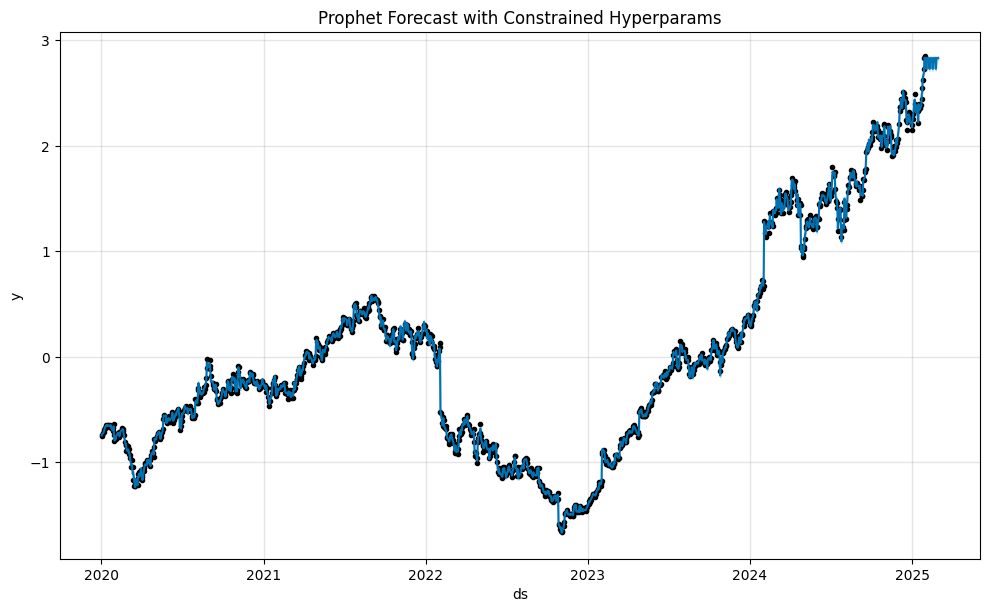


All done! Review the CV summary, forecast plot, and hold-out if available.


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# =========================
# 1. Data Loading & Scaling
# =========================
# Adjust this to your actual scaled CSV or DataFrame
# e.g., "df_scaled" is your final scaled DataFrame with columns:
# ["Date", "Close", "High", "Low", "Volume", "Tomorrow", ...]
# df = pd.read_csv("meta_scaled.csv")

# Make sure 'Date' is datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.dropna(subset=["Date"], inplace=True)

df.dropna(subset=["Tomorrow"], inplace=True)

# =========================
# 2. Correlation-Based Feature Selection
# =========================
# We'll keep 'Tomorrow' if present, but let's be cautious about data leaks.
# You can set correlation_threshold as you like, e.g. 0.4 or 0.3, etc.
correlation_threshold = 0.4
corr_target = df.corr()["Close"].drop(["Close"])
candidate_regressors = corr_target[abs(corr_target) >= correlation_threshold].index.tolist()

# Force-keep "Tomorrow" if you want, even if correlation < threshold
if "Tomorrow" in df.columns and "Tomorrow" not in candidate_regressors:
    candidate_regressors.append("Tomorrow")

print("Candidate Regressors:", candidate_regressors)

# =========================
# 3. Prepare Prophet Data
# =========================
# Rename 'Date' to 'ds' and 'Close' to 'y' as required by Prophet
df_prophet = df.rename(columns={"Date": "ds", "Close": "y"})

# =========================
# 4. Hyperparameter Tuning (Optuna)
# =========================
# Modify the objective function to avoid including 'ds' or 'y' as regressors
def objective(trial):
    # Constrained hyperparameter ranges
    cps = trial.suggest_float("changepoint_prior_scale", 0.005, 0.05, log=True)
    sps = trial.suggest_float("seasonality_prior_scale", 1.0, 10.0)
    iwidth = trial.suggest_float("interval_width", 0.6, 0.95, step=0.05)
    use_daily = trial.suggest_categorical("daily_seasonality", [False, True])

    # Build Prophet with fewer changepoints
    model_tmp = Prophet(
        changepoint_prior_scale=cps,
        seasonality_prior_scale=sps,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=use_daily,
        interval_width=iwidth,
        n_changepoints=10  # limit complexity
    )

    # Add regressors from candidate list, excluding 'ds' and 'y'
    for reg in candidate_regressors:
        if reg in ["ds", "y"]:  # Avoid adding 'ds' or 'y'
            continue
        # Let trial decide if we actually use the regressor
        use_reg = trial.suggest_categorical(f"use_{reg}", [False, True])
        if use_reg:
            model_tmp.add_regressor(reg)

    # Fit on full dataset
    model_tmp.fit(df_prophet)

    # Cross-validation (example: ~2000 days initial, 180 days period, horizon=30 days)
    cv_results = cross_validation(
        model_tmp,
        initial="2000 days",
        period="180 days",
        horizon="30 days"
    )

    metrics_df = performance_metrics(cv_results)
    # We'll minimize MAPE
    return metrics_df["mape"].mean()

# =========================
# 5. Multiple CV Horizons
# =========================
# If you want to experiment with different horizons (7, 14, 30, etc.),
# you can run multiple short Optuna studies or just do a loop with the best params.

horizons_to_try = ["7 days", "14 days", "30 days"]
cv_results_summary = []

# Rebuild a final model with best params but for each horizon
for horizon in horizons_to_try:
    # Rebuild model with best params
    final_model = Prophet(
        changepoint_prior_scale=best_params["changepoint_prior_scale"],
        seasonality_prior_scale=best_params["seasonality_prior_scale"],
        interval_width=best_params["interval_width"],
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=best_params["daily_seasonality"],
        n_changepoints=10
    )

    # For each reg in candidate_regressors, check best_params dict
    for reg in candidate_regressors:
        param_name = f"use_{reg}"
        if param_name in best_params and best_params[param_name] is True:
            final_model.add_regressor(reg)

    final_model.fit(df_prophet)

    # Now do cross-validation with the horizon in the loop
    cv_df = cross_validation(
        final_model,
        initial="1000 days",
        period="180 days",
        horizon=horizon
    )
    metrics_df = performance_metrics(cv_df)

    row = {
        "horizon": horizon,
        "mape": metrics_df["mape"].mean(),
        "rmse": metrics_df["rmse"].mean(),
        "mae": metrics_df["mae"].mean()
    }
    cv_results_summary.append(row)

cv_summary_df = pd.DataFrame(cv_results_summary)
print("\nCross-Validation Summary by horizon:")
print(cv_summary_df)

# Pick whichever horizon you truly care about or whichever is best

# =========================
# 6. Build Final Model & Forecast
# =========================
# Let's assume we pick "30 days" as the final horizon
final_horizon = "30 days"  # or choose from the summary above

final_model = Prophet(
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    seasonality_prior_scale=best_params["seasonality_prior_scale"],
    interval_width=best_params["interval_width"],
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=best_params["daily_seasonality"],
    n_changepoints=10
)
# Track the regressors actually being used
used_regressors = []

for reg in candidate_regressors:
    param_name = f"use_{reg}"
    if param_name in best_params and best_params[param_name] is True:
        final_model.add_regressor(reg)
        used_regressors.append(reg)

# Fit the model
final_model.fit(df_prophet)

# Create future dataframe
future_period = 30
future_df = final_model.make_future_dataframe(periods=future_period)

# Fill in future values for each used regressor
# Strategy: forward-fill from the last row of df_prophet
last_known = df_prophet.iloc[-1]

for reg in used_regressors:
    if reg not in df_prophet.columns:
        raise ValueError(f"Regressor '{reg}' is not present in df_prophet!")
    # Fill past values
    future_df[reg] = df_prophet[reg].values.tolist() + [last_known[reg]] * future_period

# Predict
forecast = final_model.predict(future_df)

# Plot forecast
fig1 = final_model.plot(forecast)
plt.title("Prophet Forecast with Constrained Hyperparams")
plt.show()

# =========================
# 7. (Optional) Final Hold-Out Test
# =========================
# If you have a final chunk of data you never used in training or CV,
# do a real hold-out check:
"""
holdout_start_date = "2024-12-01"
df_holdout = df_prophet[df_prophet["ds"] >= holdout_start_date].copy()
# compare forecast vs actual
"""

# =========================
# Done!
# =========================

print("\nAll done! Review the CV summary, forecast plot, and hold-out if available.")


In [52]:
meta = df.copy()


✅ Selected Regressors for Forecasting:
['Low', 'High', 'Open', 'Tomorrow']


06:15:20 - cmdstanpy - INFO - Chain [1] start processing
06:15:20 - cmdstanpy - INFO - Chain [1] done processing
06:15:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:15:21 - cmdstanpy - INFO - Chain [1] start processing
06:15:27 - cmdstanpy - INFO - Chain [1] done processing
06:15:27 - cmdstanpy - INFO - Chain [1] start processing
06:15:28 - cmdstanpy - INFO - Chain [1] done processing
06:15:29 - cmdstanpy - INFO - Chain [1] start processing
06:15:29 - cmdstanpy - INFO - Chain [1] done processing
06:15:30 - cmdstanpy - INFO - Chain [1] start processing
06:15:30 - cmdstanpy - INFO - Chain [1] done processing
06:15:31 - cmdstanpy - INFO - Chain [1] start processing
06:15:31 - cmdstanpy - INFO - Chain [1] done processing


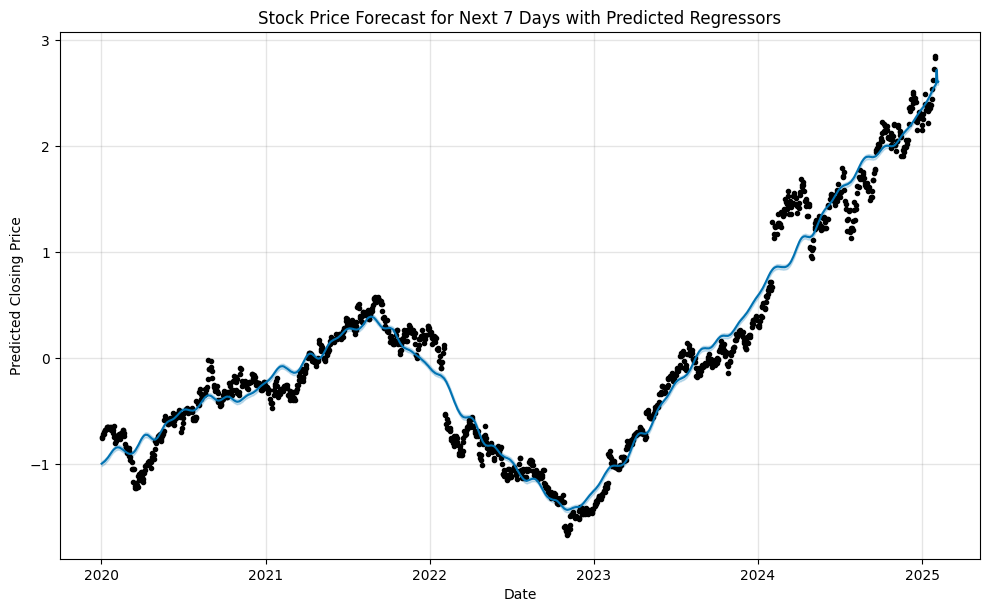


✅ 7-Day Forecast Results:
             ds      yhat  yhat_lower  yhat_upper
1276 2025-01-30  2.576956    2.553240    2.600595
1277 2025-01-31  2.583286    2.560667    2.607382
1278 2025-02-01  2.713514    2.690932    2.737898
1279 2025-02-02  2.718751    2.694546    2.742410
1280 2025-02-03  2.599775    2.577360    2.622067
1281 2025-02-04  2.603039    2.578648    2.624115
1282 2025-02-05  2.607724    2.584278    2.628461


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]06:15:33 - cmdstanpy - INFO - Chain [1] start processing
06:15:33 - cmdstanpy - INFO - Chain [1] done processing
06:15:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:15:34 - cmdstanpy - INFO - Chain [1] start processing
06:15:36 - cmdstanpy - INFO - Chain [1] done processing
 14%|████████████                                                                        | 1/7 [00:03<00:18,  3.09s/it]06:15:36 - cmdstanpy - INFO - Chain [1] start processing
06:15:36 - cmdstanpy - INFO - Chain [1] done processing
06:15:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:15:37 - cmdstanpy - INFO - Chain [1] start processing
06:15:40 - cmdstanpy - INFO - Chain [1] done processin


✅ Model Performance Metrics:
  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.000951  0.030838  0.025490  0.073767  0.016291  0.082536   
1  2 days  0.000275  0.016577  0.013758  0.035236  0.028232  0.034273   
2  3 days  0.000564  0.023749  0.022241  0.166302  0.036786  0.128518   
3  4 days  0.001830  0.042781  0.033681  0.043027  0.030860  0.042671   
4  5 days  0.000202  0.014211  0.011654  0.007706  0.008413  0.007738   
5  6 days  0.000963  0.031035  0.024772  0.079278  0.023374  0.090489   
6  7 days  0.000536  0.023155  0.015140  0.016515  0.007946  0.016796   

   coverage  
0       0.8  
1       0.8  
2       0.4  
3       0.8  
4       0.8  
5       0.6  
6       1.0  


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics



meta = df.copy()


# Ensure Date column is in datetime format
meta["Date"] = pd.to_datetime(meta["Date"])

# Compute correlation of features with the target (Close price)
correlation_threshold = 0.5  # Adjust as needed
correlations = meta.corr()["Close"].sort_values(ascending=False)

# Select only highly correlated regressors, excluding 'Close' and 'Date'
selected_regressors = [
    col for col in correlations.index if col not in ["Close", "Date"] and abs(correlations[col]) >= correlation_threshold
]

# 🔥 Print selected features
print("\n✅ Selected Regressors for Forecasting:")
print(selected_regressors)

# Prepare data for Prophet
df_prophet = meta.rename(columns={"Date": "ds", "Close": "y"})

# Initialize Prophet model
model = Prophet(changepoint_prior_scale=0.0009, seasonality_prior_scale=3, daily_seasonality=True)

# Add selected regressors
for reg in selected_regressors:
    model.add_regressor(reg)

# Fit the model
model.fit(df_prophet)

# Create a future dataframe for 7-day forecast
future = model.make_future_dataframe(periods=7)

# 🔥 Predict future values for each regressor using a separate Prophet model
for reg in selected_regressors:
    regressor_df = df_prophet[["ds", reg]].rename(columns={reg: "y"})  # Prepare data
    regressor_model = Prophet()  # New Prophet model for regressor
    regressor_model.fit(regressor_df)  # Fit the model

    # Create future dates for regressor
    future_regressor = regressor_model.make_future_dataframe(periods=7)
    regressor_forecast = regressor_model.predict(future_regressor)

    # Use predicted values for the regressor
    future[reg] = regressor_forecast["yhat"]

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title("Stock Price Forecast for Next 7 Days with Predicted Regressors")
plt.xlabel("Date")
plt.ylabel("Predicted Closing Price")
plt.show()

# Display forecasted values for the next 7 days
forecast_results = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(7)
print("\n✅ 7-Day Forecast Results:")
print(forecast_results)

# Perform cross-validation to evaluate accuracy
cv_results = cross_validation(model, initial="730 days", period="180 days", horizon="7 days")

# Calculate performance metrics
metrics = performance_metrics(cv_results)

# Display model performance metrics
print("\n✅ Model Performance Metrics:")
print(metrics)


In [54]:
# Calculate Accuracy from MAPE
metrics["accuracy"] = 100 - (metrics["mape"] * 100)

# Display Accuracy
print("\n✅ Model Accuracy in Percentage:")
print(metrics[["horizon", "accuracy"]])


✅ Model Accuracy in Percentage:
  horizon   accuracy
0  1 days  92.623309
1  2 days  96.476358
2  3 days  83.369777
3  4 days  95.697307
4  5 days  99.229373
5  6 days  92.072194
6  7 days  98.348469


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]06:16:17 - cmdstanpy - INFO - Chain [1] start processing
06:16:17 - cmdstanpy - INFO - Chain [1] done processing
06:16:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:16:17 - cmdstanpy - INFO - Chain [1] start processing
06:16:20 - cmdstanpy - INFO - Chain [1] done processing
 14%|████████████                                                                        | 1/7 [00:02<00:17,  2.91s/it]06:16:20 - cmdstanpy - INFO - Chain [1] start processing
06:16:20 - cmdstanpy - INFO - Chain [1] done processing
06:16:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:16:20 - cmdstanpy - INFO - Chain [1] start processing
06:16:24 - cmdstanpy - INFO - Chain [1] done processin

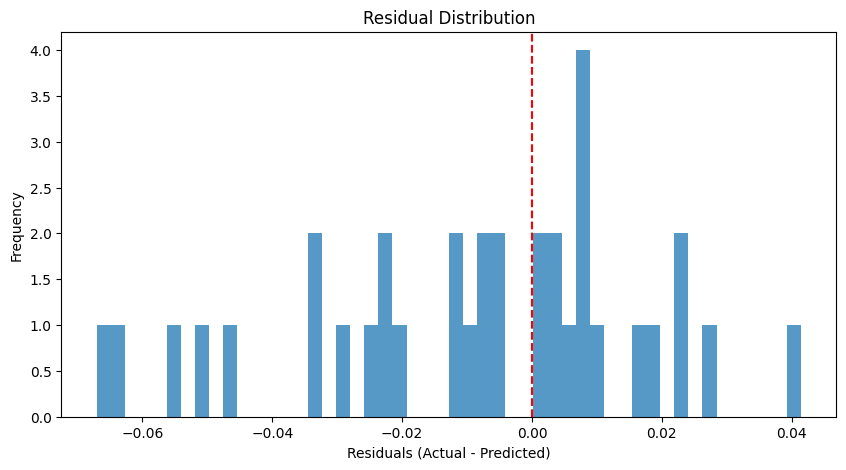

In [55]:
import matplotlib.pyplot as plt

df_cv = cross_validation(model, initial="730 days", period="180 days", horizon="7 days")

plt.figure(figsize=(10, 5))
plt.hist(df_cv["y"] - df_cv["yhat"], bins=50, alpha=0.75)
plt.axvline(0, color="red", linestyle="dashed")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()


In [56]:
latest_price = df_prophet["y"].iloc[-1]

metrics["rmse_pct"] = (metrics["rmse"] / latest_price) * 100

print("\n✅ RMSE as Percentage of Stock Price:")
print(metrics[["horizon", "rmse", "rmse_pct"]])



✅ RMSE as Percentage of Stock Price:
  horizon      rmse  rmse_pct
0  1 days  0.030838  1.081797
1  2 days  0.016577  0.581528
2  3 days  0.023749  0.833119
3  4 days  0.042781  1.500734
4  5 days  0.014211  0.498524
5  6 days  0.031035  1.088702
6  7 days  0.023155  0.812262


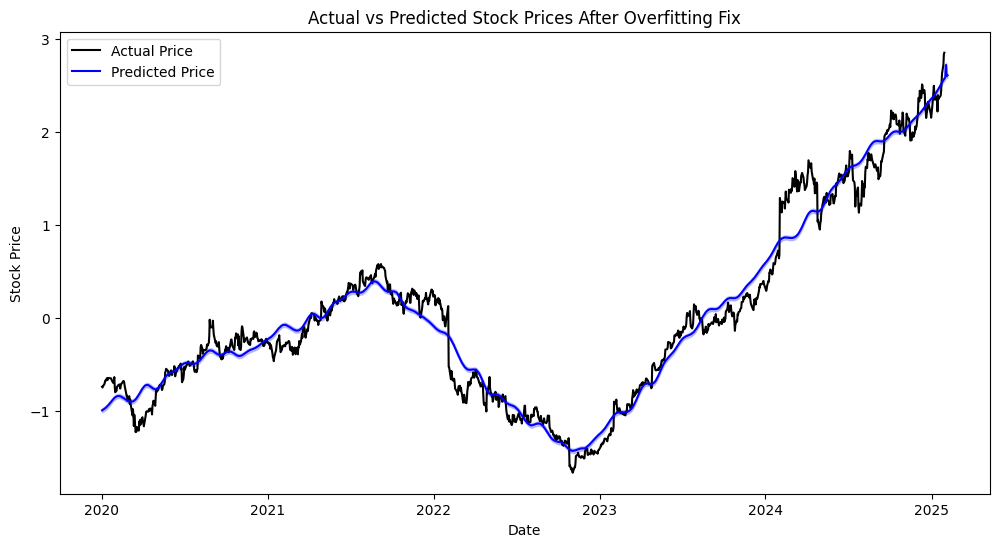

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Actual Price", color="black")
plt.plot(forecast["ds"], forecast["yhat"], label="Predicted Price", color="blue")
plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], color="blue", alpha=0.2)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices After Overfitting Fix")
plt.legend()
plt.show()
